In [1]:
# unique token for this session 
SESSION_TOKEN = 'simple_consensus_example'

In [2]:
import logging
import matplotlib.pyplot as plt
from pathlib import Path
from graphviz import Digraph
from consensus_simple.train_consensus import main, get_cifar10_train_loaders
from resnet import resnet20

In [3]:
# set your paths for loading dataset and stats saving
BASE_DIR = Path().cwd()

SAVE_DIR = BASE_DIR.joinpath('stat_dir').joinpath(SESSION_TOKEN)
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DATASET_NAME = 'cifar10'
DATASET_DIR = BASE_DIR.parent / 'distributed-learning' / 'data' / DATASET_NAME

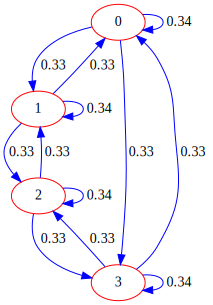

In [4]:
n_agents = 4

topology = {
    0: {0: 0.34, 
        1: 0.33,
        3: 0.33,
       },
    1: {1: 0.34, 
        0: 0.33,
        2: 0.33,
       },
    2: {2: 0.34, 
        1: 0.33,
        3: 0.33,
       },
    3: {3: 0.34, 
        2: 0.33,
        0: 0.33,
       },
}

g = Digraph(name='topology', directory=SAVE_DIR)
g.attr('node', color='red')
g.attr('edge', color='blue')
g.attr(size='8,5')

for agent, neighbors in topology.items():
    g.node(str(agent))
    for neighbor, w in neighbors.items():
        g.edge(str(neighbor), str(agent), label="{:.02f}".format(w))
g.save()
g

In [5]:
def get_logger(log_file_path='logs.log'):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)

    fh = logging.FileHandler(log_file_path)
    fh.setLevel(logging.INFO)

    ch = logging.StreamHandler()
    #ch.setLevel(logging.DEBUG)
    ch.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)

    logger.addHandler(fh)
    logger.addHandler(ch)

    return logger

In [6]:
dataset_sizes = {agent_name: int(50000/len(topology)) for agent_name in topology}
print(sum(dataset_sizes.values()))

train_freqs = {agent_name: 1 for agent_name in topology}
consensus_freqs = train_freqs

50000


In [7]:
_train_loaders = get_cifar10_train_loaders({
    'dataset_dir': DATASET_DIR,
    'dataset_sizes': dataset_sizes,
    'train_batch_size': 32,
})
print('Info about future train loaders:')
for agent_name, loader in _train_loaders.items():
    print('For {} agent {} batches'.format(agent_name, len(loader)))

Files already downloaded and verified
Info about future train loaders:
For 0 agent 391 batches
For 1 agent 391 batches
For 2 agent 391 batches
For 3 agent 391 batches


In [8]:
def lr_schedule(iteration):
    factor = args['n_agents'] if args['use_lsr'] else 1.0
    if iteration < 391*5:  # gradual warmup
        factor = factor*iteration/(391*5)
    if iteration >= 391*81:
        factor /= 10
    if iteration >= 391*122:
        factor /= 10
    return factor

In [9]:
args = {
    'dataset_name': DATASET_NAME,
    'dataset_dir': DATASET_DIR,
    
    # путь до папки куда сохраняется статистика
    'save_path': SAVE_DIR,

    'train_batch_size': 32,
    'test_batch_size': 128,

    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'lr_schedule': lr_schedule,
    
    'topology': topology,
    'n_agents': len(topology),
    
    # True, если хотим перед обучением параметры всех агентов сделать идентичными 
    'equalize_start_params': True,

    # True если хотим learning_rate умножить на количество агентов в сети
    'use_lsr': True,
    
    # Задает количество итераций.
    # Если <= 200, то считается количеством эпох
    # и в этом случае умножается на размер самого большого куска датасета. 
    'num_epochs': 200,
    
    # Частота обучения одного батча для каждого агента. Измеряется в батчах.
    'train_freqs': train_freqs, 
    
    # Частота усреднения параметров для каждого агента. Измеряется в батчах.
    # Если хочется усредняться после каждого батча, должно быть равным train_freqs
    'consensus_freqs': consensus_freqs,
    
    # Частота сбора статистики. Измеряется в батчах.
    'stat_freq': 391,
    
    # Количество данных для каждого агента. 
    # Значения должны суммироваться к размеру датасета. Для cifar10 это 50000. 
    'dataset_sizes': dataset_sizes,

    'model': resnet20,
    
    'checkpoint_path': SAVE_DIR,
}

args['logger'] = get_logger(log_file_path=SAVE_DIR.joinpath('logs.log'))

In [10]:
main(args)

2021-03-29 19:44:45,684 - __main__ - INFO - START with args 
{'dataset_name': 'cifar10', 'dataset_dir': PosixPath('/home/sergey/Documents/homeworks/distrib_learning/distributed-learning/data/cifar10'), 'save_path': PosixPath('/home/sergey/Documents/homeworks/distrib_learning/pytorch_resnet_cifar10/stat_dir/simple_consensus_example'), 'train_batch_size': 32, 'test_batch_size': 128, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': <function lr_schedule at 0x7efd25c13430>, 'topology': {0: {0: 0.34, 1: 0.33, 3: 0.33}, 1: {1: 0.34, 0: 0.33, 2: 0.33}, 2: {2: 0.34, 1: 0.33, 3: 0.33}, 3: {3: 0.34, 2: 0.33, 0: 0.33}}, 'n_agents': 4, 'equalize_start_params': True, 'use_lsr': True, 'num_epochs': 200, 'train_freqs': {0: 1, 1: 1, 2: 1, 3: 1}, 'consensus_freqs': {0: 1, 1: 1, 2: 1, 3: 1}, 'stat_freq': 391, 'dataset_sizes': {0: 12500, 1: 12500, 2: 12500, 3: 12500}, 'model': <function resnet20 at 0x7efd25d9fa60>, 'checkpoint_path': PosixPath('/home/sergey/Documents/homeworks/distrib_l

Files already downloaded and verified


2021-03-29 19:44:47,052 - __main__ - INFO - Train loaders successfully prepared
2021-03-29 19:44:50,264 - __main__ - INFO - 4 Models successfully prepared
2021-03-29 19:44:50,264 - __main__ - INFO - Mixer successfully prepared
2021-03-29 19:44:50,265 - __main__ - INFO - Preparing took 0:00:04
/home/sergey/anaconda3/envs/distrib-learning/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:218: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
2021-03-29 19:44:50,803 - __main__ - INFO - Agent 0 successfully loaded from checkpoint
2021-03-29 19:44:51,677 - __main__ - INFO - Agent 1 successfully loaded from checkpoint
2021-03-29 19:44:51,915 - __main__ - INFO - Agent 2 successfully loaded from checkpoint
2021-03-29 19:44:52,129 - __main__ - INFO - Agent 3 successfully loaded from checkpoint
2021-03-29 19:44:52,132 - __main__ - INFO - Training started from 5084 iteration
2021-03-29 19:46

2021-03-29 19:48:39,009 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.015624388064146042
2021-03-29 19:48:39,013 - __main__ - INFO - StatisticCollector 3 add train_precision with value 82.87200164794922
2021-03-29 19:48:39,021 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 19:48:39,091 - __main__ - INFO - Iteration: 6256 / 78200
2021-03-29 19:48:42,509 - __main__ - INFO - StatisticCollector 0 add val_precision with value 76.12000274658203
2021-03-29 19:48:42,510 - __main__ - INFO - StatisticCollector 0 add val_loss with value 59.9736690223217
2021-03-29 19:48:45,907 - __main__ - INFO - StatisticCollector 1 add val_precision with value 75.80000305175781
2021-03-29 19:48:45,908 - __main__ - INFO - StatisticCollector 1 add val_loss with value 61.159629076719284
2021-03-29 19:48:49,311 - __main__ - INFO - StatisticCollector 2 add val_precision with value 72.70999908447266
2021-03-29 19:48:49,312 - __main__ - INFO - StatisticCollector 2 add 

2021-03-29 19:52:34,780 - __main__ - INFO - StatisticCollector 0 add train_precision with value 83.48799896240234
2021-03-29 19:52:34,781 - __main__ - INFO - StatisticCollector 0 add lr with value 0.4
2021-03-29 19:52:34,808 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.015577950131893158
2021-03-29 19:52:34,809 - __main__ - INFO - StatisticCollector 1 add train_precision with value 82.90399932861328
2021-03-29 19:52:34,809 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2021-03-29 19:52:34,836 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.015504747554063798
2021-03-29 19:52:34,836 - __main__ - INFO - StatisticCollector 2 add train_precision with value 82.96800231933594
2021-03-29 19:52:34,839 - __main__ - INFO - StatisticCollector 2 add lr with value 0.4
2021-03-29 19:52:34,870 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.015119107314944267
2021-03-29 19:52:34,871 - __main__ - INFO - StatisticCollecto

2021-03-29 19:55:25,946 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 116.67102, 1: 120.83196, 2: 128.83345, 3: 123.36483}
2021-03-29 19:55:25,949 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.34738088, 1: 0.34904966, 2: 0.38241553, 3: 0.36945975}
2021-03-29 19:55:25,951 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.026856422, 1: 0.018609345, 2: 0.020033479, 3: 0.02135837}
2021-03-29 19:55:25,953 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.73424220085144
2021-03-29 19:55:25,954 - __main__ - INFO - Elapsed time : 0:10:38
2021-03-29 19:56:30,942 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.015066961286067963
2021-03-29 19:56:30,943 - __main__ - INFO - StatisticCollector 0 add train_precision with value 83.33599853515625
2021-03-29 19:56:30,945 - __main__ - INFO - Statisti

2021-03-29 19:59:12,108 - __main__ - INFO - StatisticCollector 0 add val_loss with value 50.30687654018402
2021-03-29 19:59:15,499 - __main__ - INFO - StatisticCollector 1 add val_precision with value 80.4800033569336
2021-03-29 19:59:15,500 - __main__ - INFO - StatisticCollector 1 add val_loss with value 47.24633181095123
2021-03-29 19:59:18,901 - __main__ - INFO - StatisticCollector 2 add val_precision with value 79.8499984741211
2021-03-29 19:59:18,902 - __main__ - INFO - StatisticCollector 2 add val_loss with value 49.34141328930855
2021-03-29 19:59:22,293 - __main__ - INFO - StatisticCollector 3 add val_precision with value 78.04000091552734
2021-03-29 19:59:22,294 - __main__ - INFO - StatisticCollector 3 add val_loss with value 53.650649279356
2021-03-29 19:59:22,318 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 958.3865356445312
2021-03-29 19:59:22,326 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {

2021-03-29 20:03:05,011 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2021-03-29 20:03:05,038 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.014891829949617385
2021-03-29 20:03:05,039 - __main__ - INFO - StatisticCollector 2 add train_precision with value 83.61599731445312
2021-03-29 20:03:05,040 - __main__ - INFO - StatisticCollector 2 add lr with value 0.4
2021-03-29 20:03:05,071 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.014333596773147583
2021-03-29 20:03:05,072 - __main__ - INFO - StatisticCollector 3 add train_precision with value 84.2239990234375
2021-03-29 20:03:05,073 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 20:03:05,109 - __main__ - INFO - Iteration: 10557 / 78200
2021-03-29 20:03:08,508 - __main__ - INFO - StatisticCollector 0 add val_precision with value 80.5199966430664
2021-03-29 20:03:08,509 - __main__ - INFO - StatisticCollector 0 add val_loss with value 46.11309292912483
2

2021-03-29 20:05:56,262 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.01835823, 1: 0.019268572, 2: 0.02611959, 3: 0.019589067}
2021-03-29 20:05:56,266 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.73537683486938
2021-03-29 20:05:56,268 - __main__ - INFO - Elapsed time : 0:21:08
2021-03-29 20:07:01,290 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.01441654114484787
2021-03-29 20:07:01,291 - __main__ - INFO - StatisticCollector 0 add train_precision with value 84.3280029296875
2021-03-29 20:07:01,292 - __main__ - INFO - StatisticCollector 0 add lr with value 0.4
2021-03-29 20:07:01,320 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.014683675956726074
2021-03-29 20:07:01,321 - __main__ - INFO - StatisticCollector 1 add train_precision with value 83.72799682617188
2021-03-29 20:07:01,322 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2

2021-03-29 20:09:49,249 - __main__ - INFO - StatisticCollector 2 add val_precision with value 76.79000091552734
2021-03-29 20:09:49,250 - __main__ - INFO - StatisticCollector 2 add val_loss with value 60.56601411104202
2021-03-29 20:09:52,646 - __main__ - INFO - StatisticCollector 3 add val_precision with value 75.5199966430664
2021-03-29 20:09:52,647 - __main__ - INFO - StatisticCollector 3 add val_loss with value 64.90218883752823
2021-03-29 20:09:52,667 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 25204.873046875
2021-03-29 20:09:52,679 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 142.65924, 1: 153.68848, 2: 146.57747, 3: 141.9089}
2021-03-29 20:09:52,680 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.42026657, 1: 0.44997853, 2: 0.4340257, 3: 0.41636863}
2021-03-29 20:09:52,682 - __main__ - INFO - StatisticCollector global_statistic add param_deviat

2021-03-29 20:13:35,464 - __main__ - INFO - StatisticCollector 2 add lr with value 0.4
2021-03-29 20:13:35,493 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.01378956057190895
2021-03-29 20:13:35,494 - __main__ - INFO - StatisticCollector 3 add train_precision with value 85.08000183105469
2021-03-29 20:13:35,495 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 20:13:35,533 - __main__ - INFO - Iteration: 13685 / 78200
2021-03-29 20:13:38,935 - __main__ - INFO - StatisticCollector 0 add val_precision with value 80.30000305175781
2021-03-29 20:13:38,936 - __main__ - INFO - StatisticCollector 0 add val_loss with value 46.74202883243561
2021-03-29 20:13:42,330 - __main__ - INFO - StatisticCollector 1 add val_precision with value 80.31999969482422
2021-03-29 20:13:42,331 - __main__ - INFO - StatisticCollector 1 add val_loss with value 47.45078432559967
2021-03-29 20:13:45,732 - __main__ - INFO - StatisticCollector 2 add val_precision with value 

2021-03-29 20:16:26,820 - __main__ - INFO - Elapsed time : 0:31:39
2021-03-29 20:17:31,858 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.01367229494035244
2021-03-29 20:17:31,859 - __main__ - INFO - StatisticCollector 0 add train_precision with value 85.27200317382812
2021-03-29 20:17:31,860 - __main__ - INFO - StatisticCollector 0 add lr with value 0.4
2021-03-29 20:17:31,889 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.014206531838178634
2021-03-29 20:17:31,890 - __main__ - INFO - StatisticCollector 1 add train_precision with value 84.35199737548828
2021-03-29 20:17:31,891 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2021-03-29 20:17:31,918 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.014238386606574059
2021-03-29 20:17:31,920 - __main__ - INFO - StatisticCollector 2 add train_precision with value 84.36000061035156
2021-03-29 20:17:31,922 - __main__ - INFO - StatisticCollector 2 add lr with value

2021-03-29 20:20:23,297 - __main__ - INFO - StatisticCollector 3 add val_loss with value 46.71912798285484
2021-03-29 20:20:23,318 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 2098.992431640625
2021-03-29 20:20:23,330 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 126.0085, 1: 123.110435, 2: 126.21151, 3: 124.29624}
2021-03-29 20:20:23,334 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.3653252, 1: 0.35948464, 2: 0.36342978, 3: 0.35663864}
2021-03-29 20:20:23,338 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.019021988, 1: 0.022397518, 2: 0.0152846575, 3: 0.019925714}
2021-03-29 20:20:23,341 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.8779149055481
2021-03-29 20:20:23,362 - __main__ - INFO - Elapsed time : 0:35:35
2021-03-29 20:21:28,459 - __main__ - INFO - St

2021-03-29 20:24:06,157 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 20:24:06,201 - __main__ - INFO - Iteration: 16813 / 78200
2021-03-29 20:24:09,597 - __main__ - INFO - StatisticCollector 0 add val_precision with value 81.6500015258789
2021-03-29 20:24:09,598 - __main__ - INFO - StatisticCollector 0 add val_loss with value 46.88508668541908
2021-03-29 20:24:13,002 - __main__ - INFO - StatisticCollector 1 add val_precision with value 82.0
2021-03-29 20:24:13,003 - __main__ - INFO - StatisticCollector 1 add val_loss with value 46.3230881690979
2021-03-29 20:24:16,398 - __main__ - INFO - StatisticCollector 2 add val_precision with value 80.93000030517578
2021-03-29 20:24:16,399 - __main__ - INFO - StatisticCollector 2 add val_loss with value 48.69068017601967
2021-03-29 20:24:19,797 - __main__ - INFO - StatisticCollector 3 add val_precision with value 80.9800033569336
2021-03-29 20:24:19,798 - __main__ - INFO - StatisticCollector 3 add val_loss with value 48

2021-03-29 20:28:02,648 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.014357204828858376
2021-03-29 20:28:02,649 - __main__ - INFO - StatisticCollector 1 add train_precision with value 84.1760025024414
2021-03-29 20:28:02,650 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2021-03-29 20:28:02,678 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.014042092963457108
2021-03-29 20:28:02,680 - __main__ - INFO - StatisticCollector 2 add train_precision with value 84.60800170898438
2021-03-29 20:28:02,681 - __main__ - INFO - StatisticCollector 2 add lr with value 0.4
2021-03-29 20:28:02,715 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.01364306296467781
2021-03-29 20:28:02,716 - __main__ - INFO - StatisticCollector 3 add train_precision with value 84.80000305175781
2021-03-29 20:28:02,717 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 20:28:02,756 - __main__ - INFO - Iteration: 17986 / 

2021-03-29 20:30:54,055 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.35664102, 1: 0.3493823, 2: 0.37680846, 3: 0.35426787}
2021-03-29 20:30:54,057 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.026325583, 1: 0.020356536, 2: 0.02349782, 3: 0.024123013}
2021-03-29 20:30:54,060 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.82556676864624
2021-03-29 20:30:54,064 - __main__ - INFO - Elapsed time : 0:46:06
2021-03-29 20:31:59,157 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.013702808804512023
2021-03-29 20:31:59,159 - __main__ - INFO - StatisticCollector 0 add train_precision with value 85.0719985961914
2021-03-29 20:31:59,160 - __main__ - INFO - StatisticCollector 0 add lr with value 0.4
2021-03-29 20:31:59,190 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.013896765276789666
2021-03-29 20:31:59,191 - 

2021-03-29 20:34:43,739 - __main__ - INFO - StatisticCollector 1 add val_loss with value 42.535807222127914
2021-03-29 20:34:47,140 - __main__ - INFO - StatisticCollector 2 add val_precision with value 81.81999969482422
2021-03-29 20:34:47,142 - __main__ - INFO - StatisticCollector 2 add val_loss with value 43.06048026680946
2021-03-29 20:34:50,540 - __main__ - INFO - StatisticCollector 3 add val_precision with value 82.47000122070312
2021-03-29 20:34:50,541 - __main__ - INFO - StatisticCollector 3 add val_loss with value 41.062821596860886
2021-03-29 20:34:50,563 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 1547.781982421875
2021-03-29 20:34:50,570 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 121.780975, 1: 120.31412, 2: 127.43962, 3: 122.44298}
2021-03-29 20:34:50,573 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.35390925, 1: 0.35106364, 2: 0.374916

2021-03-29 20:38:33,582 - __main__ - INFO - StatisticCollector 2 add train_precision with value 85.2239990234375
2021-03-29 20:38:33,583 - __main__ - INFO - StatisticCollector 2 add lr with value 0.4
2021-03-29 20:38:33,616 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.01355470889866352
2021-03-29 20:38:33,617 - __main__ - INFO - StatisticCollector 3 add train_precision with value 85.39199829101562
2021-03-29 20:38:33,617 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 20:38:33,656 - __main__ - INFO - Iteration: 21114 / 78200
2021-03-29 20:38:37,044 - __main__ - INFO - StatisticCollector 0 add val_precision with value 81.58000183105469
2021-03-29 20:38:37,045 - __main__ - INFO - StatisticCollector 0 add val_loss with value 46.02758431434631
2021-03-29 20:38:40,440 - __main__ - INFO - StatisticCollector 1 add val_precision with value 79.73999786376953
2021-03-29 20:38:40,440 - __main__ - INFO - StatisticCollector 1 add val_loss with value

2021-03-29 20:41:25,225 - __main__ - INFO - Elapsed time : 0:56:37
2021-03-29 20:42:30,314 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.013564605883955956
2021-03-29 20:42:30,316 - __main__ - INFO - StatisticCollector 0 add train_precision with value 85.25599670410156
2021-03-29 20:42:30,317 - __main__ - INFO - StatisticCollector 0 add lr with value 0.4
2021-03-29 20:42:30,347 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.013489855833649636
2021-03-29 20:42:30,348 - __main__ - INFO - StatisticCollector 1 add train_precision with value 85.19999694824219
2021-03-29 20:42:30,349 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2021-03-29 20:42:30,379 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.013315741293430328
2021-03-29 20:42:30,380 - __main__ - INFO - StatisticCollector 2 add train_precision with value 85.36000061035156
2021-03-29 20:42:30,381 - __main__ - INFO - StatisticCollector 2 add lr with valu

2021-03-29 20:45:21,875 - __main__ - INFO - StatisticCollector 3 add val_loss with value 48.16800716519356
2021-03-29 20:45:21,897 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 3729.801513671875
2021-03-29 20:45:21,905 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 149.85193, 1: 151.39027, 2: 147.38847, 3: 146.16748}
2021-03-29 20:45:21,908 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.43611473, 1: 0.4346703, 2: 0.4278994, 3: 0.422397}
2021-03-29 20:45:21,913 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.024460614, 1: 0.019377083, 2: 0.02427411, 3: 0.023285866}
2021-03-29 20:45:21,919 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.86363053321838
2021-03-29 20:45:21,923 - __main__ - INFO - Elapsed time : 1:00:34
2021-03-29 20:46:27,069 - __main__ - INFO - Statis

2021-03-29 20:49:04,930 - __main__ - INFO - Iteration: 24242 / 78200
2021-03-29 20:49:08,330 - __main__ - INFO - StatisticCollector 0 add val_precision with value 82.45999908447266
2021-03-29 20:49:08,331 - __main__ - INFO - StatisticCollector 0 add val_loss with value 42.0516491830349
2021-03-29 20:49:11,732 - __main__ - INFO - StatisticCollector 1 add val_precision with value 81.72000122070312
2021-03-29 20:49:11,733 - __main__ - INFO - StatisticCollector 1 add val_loss with value 43.69449806213379
2021-03-29 20:49:15,139 - __main__ - INFO - StatisticCollector 2 add val_precision with value 82.16999816894531
2021-03-29 20:49:15,140 - __main__ - INFO - StatisticCollector 2 add val_loss with value 43.026278614997864
2021-03-29 20:49:18,537 - __main__ - INFO - StatisticCollector 3 add val_precision with value 81.62000274658203
2021-03-29 20:49:18,538 - __main__ - INFO - StatisticCollector 3 add val_loss with value 43.62741097807884
2021-03-29 20:49:18,562 - __main__ - INFO - StatisticCo

2021-03-29 20:53:01,537 - __main__ - INFO - StatisticCollector 1 add train_precision with value 84.88800048828125
2021-03-29 20:53:01,537 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2021-03-29 20:53:01,568 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.013342078679800034
2021-03-29 20:53:01,569 - __main__ - INFO - StatisticCollector 2 add train_precision with value 85.04000091552734
2021-03-29 20:53:01,569 - __main__ - INFO - StatisticCollector 2 add lr with value 0.4
2021-03-29 20:53:01,604 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.01267549943625927
2021-03-29 20:53:01,605 - __main__ - INFO - StatisticCollector 3 add train_precision with value 86.09600067138672
2021-03-29 20:53:01,606 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 20:53:01,641 - __main__ - INFO - Iteration: 25415 / 78200
2021-03-29 20:53:05,040 - __main__ - INFO - StatisticCollector 0 add val_precision with value 77.36000061

2021-03-29 20:55:53,081 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.028661847, 1: 0.030504167, 2: 0.023428082, 3: 0.020715475}
2021-03-29 20:55:53,086 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.91676163673401
2021-03-29 20:55:53,091 - __main__ - INFO - Elapsed time : 1:11:05
2021-03-29 20:56:58,148 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.012753158950805664
2021-03-29 20:56:58,149 - __main__ - INFO - StatisticCollector 0 add train_precision with value 85.97599792480469
2021-03-29 20:56:58,150 - __main__ - INFO - StatisticCollector 0 add lr with value 0.4
2021-03-29 20:56:58,186 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.013380428327918052
2021-03-29 20:56:58,187 - __main__ - INFO - StatisticCollector 1 add train_precision with value 85.61599731445312
2021-03-29 20:56:58,188 - __main__ - INFO - StatisticCollector 1 add lr with value 0

2021-03-29 20:59:46,272 - __main__ - INFO - StatisticCollector 2 add val_precision with value 78.01000213623047
2021-03-29 20:59:46,273 - __main__ - INFO - StatisticCollector 2 add val_loss with value 53.657040774822235
2021-03-29 20:59:49,663 - __main__ - INFO - StatisticCollector 3 add val_precision with value 81.5199966430664
2021-03-29 20:59:49,664 - __main__ - INFO - StatisticCollector 3 add val_loss with value 44.57432547211647
2021-03-29 20:59:49,688 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 729.75146484375
2021-03-29 20:59:49,697 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 133.7255, 1: 131.44943, 2: 124.396, 3: 125.60836}
2021-03-29 20:59:49,698 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.38444903, 1: 0.38021412, 2: 0.3566141, 3: 0.36676058}
2021-03-29 20:59:49,701 - __main__ - INFO - StatisticCollector global_statistic add param_deviati

2021-03-29 21:03:32,745 - __main__ - INFO - StatisticCollector 2 add lr with value 0.4
2021-03-29 21:03:32,778 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.01279731742322445
2021-03-29 21:03:32,779 - __main__ - INFO - StatisticCollector 3 add train_precision with value 86.10399627685547
2021-03-29 21:03:32,781 - __main__ - INFO - StatisticCollector 3 add lr with value 0.4
2021-03-29 21:03:32,821 - __main__ - INFO - Iteration: 28543 / 78200
2021-03-29 21:03:36,211 - __main__ - INFO - StatisticCollector 0 add val_precision with value 85.06999969482422
2021-03-29 21:03:36,212 - __main__ - INFO - StatisticCollector 0 add val_loss with value 35.790254190564156
2021-03-29 21:03:39,604 - __main__ - INFO - StatisticCollector 1 add val_precision with value 83.36000061035156
2021-03-29 21:03:39,605 - __main__ - INFO - StatisticCollector 1 add val_loss with value 40.10269859433174
2021-03-29 21:03:43,000 - __main__ - INFO - StatisticCollector 2 add val_precision with value

2021-03-29 21:06:24,351 - __main__ - INFO - Elapsed time : 1:21:36
2021-03-29 21:07:29,447 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.01310533649623394
2021-03-29 21:07:29,449 - __main__ - INFO - StatisticCollector 0 add train_precision with value 85.58399963378906
2021-03-29 21:07:29,449 - __main__ - INFO - StatisticCollector 0 add lr with value 0.4
2021-03-29 21:07:29,483 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.013605811638832092
2021-03-29 21:07:29,483 - __main__ - INFO - StatisticCollector 1 add train_precision with value 85.26399993896484
2021-03-29 21:07:29,484 - __main__ - INFO - StatisticCollector 1 add lr with value 0.4
2021-03-29 21:07:29,515 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.013144590454101563
2021-03-29 21:07:29,516 - __main__ - INFO - StatisticCollector 2 add train_precision with value 85.47200012207031
2021-03-29 21:07:29,517 - __main__ - INFO - StatisticCollector 2 add lr with value

2021-03-29 21:10:20,995 - __main__ - INFO - StatisticCollector 3 add val_loss with value 45.91137972474098
2021-03-29 21:10:21,019 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 5050.958984375
2021-03-29 21:10:21,023 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 142.20549, 1: 131.06943, 2: 139.99156, 3: 131.3059}
2021-03-29 21:10:21,026 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.4124086, 1: 0.37948152, 2: 0.412009, 3: 0.37853166}
2021-03-29 21:10:21,030 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.021238208, 1: 0.0219692, 2: 0.021276653, 3: 0.021907032}
2021-03-29 21:10:21,035 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.81917929649353
2021-03-29 21:10:21,040 - __main__ - INFO - Elapsed time : 1:25:33
2021-03-29 21:11:26,152 - __main__ - INFO - StatisticC

2021-03-29 21:14:04,111 - __main__ - INFO - Iteration: 31671 / 78200
2021-03-29 21:14:07,505 - __main__ - INFO - StatisticCollector 0 add val_precision with value 78.9000015258789
2021-03-29 21:14:07,506 - __main__ - INFO - StatisticCollector 0 add val_loss with value 51.6142737865448
2021-03-29 21:14:10,910 - __main__ - INFO - StatisticCollector 1 add val_precision with value 79.31999969482422
2021-03-29 21:14:10,911 - __main__ - INFO - StatisticCollector 1 add val_loss with value 49.79994720220566
2021-03-29 21:14:14,312 - __main__ - INFO - StatisticCollector 2 add val_precision with value 78.77999877929688
2021-03-29 21:14:14,313 - __main__ - INFO - StatisticCollector 2 add val_loss with value 51.94614642858505
2021-03-29 21:14:17,710 - __main__ - INFO - StatisticCollector 3 add val_precision with value 78.44999694824219
2021-03-29 21:14:17,711 - __main__ - INFO - StatisticCollector 3 add val_loss with value 53.135316610336304
2021-03-29 21:14:17,736 - __main__ - INFO - StatisticCol

2021-03-29 21:18:00,819 - __main__ - INFO - StatisticCollector 0 add lr with value 0.04000000000000001
2021-03-29 21:18:00,851 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.006470648955106735
2021-03-29 21:18:00,852 - __main__ - INFO - StatisticCollector 1 add train_precision with value 92.95999908447266
2021-03-29 21:18:00,853 - __main__ - INFO - StatisticCollector 1 add lr with value 0.04000000000000001
2021-03-29 21:18:00,884 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.006644469974339008
2021-03-29 21:18:00,887 - __main__ - INFO - StatisticCollector 2 add train_precision with value 92.4000015258789
2021-03-29 21:18:00,888 - __main__ - INFO - StatisticCollector 2 add lr with value 0.04000000000000001
2021-03-29 21:18:00,923 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.006356494525074959
2021-03-29 21:18:00,924 - __main__ - INFO - StatisticCollector 3 add train_precision with value 93.0
2021-03-29 21:18:00,925 - _

2021-03-29 21:20:52,468 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 173.8963165283203
2021-03-29 21:20:52,473 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 12.724727, 1: 12.258724, 2: 12.868654, 3: 11.471837}
2021-03-29 21:20:52,476 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.035854995, 1: 0.034438644, 2: 0.036247328, 3: 0.032880776}
2021-03-29 21:20:52,479 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0018879175, 1: 0.0020340383, 2: 0.0017658472, 3: 0.0022883415}
2021-03-29 21:20:52,484 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.96442317962646
2021-03-29 21:20:52,488 - __main__ - INFO - Elapsed time : 1:36:04
2021-03-29 21:21:57,977 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.005742941192239523
2021-03-29 21:21:57,979 - __main

2021-03-29 21:24:36,097 - __main__ - INFO - StatisticCollector 3 add lr with value 0.04000000000000001
2021-03-29 21:24:36,136 - __main__ - INFO - Iteration: 34799 / 78200
2021-03-29 21:24:39,526 - __main__ - INFO - StatisticCollector 0 add val_precision with value 90.98999786376953
2021-03-29 21:24:39,527 - __main__ - INFO - StatisticCollector 0 add val_loss with value 22.17557519674301
2021-03-29 21:24:42,921 - __main__ - INFO - StatisticCollector 1 add val_precision with value 90.98999786376953
2021-03-29 21:24:42,922 - __main__ - INFO - StatisticCollector 1 add val_loss with value 22.656776070594788
2021-03-29 21:24:46,317 - __main__ - INFO - StatisticCollector 2 add val_precision with value 90.88999938964844
2021-03-29 21:24:46,318 - __main__ - INFO - StatisticCollector 2 add val_loss with value 22.44560906291008
2021-03-29 21:24:49,716 - __main__ - INFO - StatisticCollector 3 add val_precision with value 90.87999725341797
2021-03-29 21:24:49,717 - __main__ - INFO - StatisticColle

2021-03-29 21:28:32,512 - __main__ - INFO - StatisticCollector 0 add train_precision with value 94.48799896240234
2021-03-29 21:28:32,513 - __main__ - INFO - StatisticCollector 0 add lr with value 0.04000000000000001
2021-03-29 21:28:32,547 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.005057919021099806
2021-03-29 21:28:32,549 - __main__ - INFO - StatisticCollector 1 add train_precision with value 94.30400085449219
2021-03-29 21:28:32,549 - __main__ - INFO - StatisticCollector 1 add lr with value 0.04000000000000001
2021-03-29 21:28:32,581 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.005007843514829874
2021-03-29 21:28:32,582 - __main__ - INFO - StatisticCollector 2 add train_precision with value 94.31199645996094
2021-03-29 21:28:32,583 - __main__ - INFO - StatisticCollector 2 add lr with value 0.04000000000000001
2021-03-29 21:28:32,617 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.004990891164541244
2021-03-29 21

2021-03-29 21:31:23,798 - __main__ - INFO - StatisticCollector 3 add val_loss with value 22.464740745723248
2021-03-29 21:31:23,817 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 562.1815795898438
2021-03-29 21:31:23,825 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 18.848879, 1: 20.385658, 2: 17.900225, 3: 17.707981}
2021-03-29 21:31:23,828 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.05338604, 1: 0.057419375, 2: 0.049909435, 3: 0.049951203}
2021-03-29 21:31:23,831 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0039924383, 1: 0.0029603243, 2: 0.0027810335, 3: 0.0025131702}
2021-03-29 21:31:23,840 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 78.78132557868958
2021-03-29 21:31:23,847 - __main__ - INFO - Elapsed time : 1:46:35
2021-03-29 21:32:28,962 - __main__ - 

2021-03-29 21:35:06,678 - __main__ - INFO - StatisticCollector 3 add train_precision with value 94.87999725341797
2021-03-29 21:35:06,678 - __main__ - INFO - StatisticCollector 3 add lr with value 0.04000000000000001
2021-03-29 21:35:06,719 - __main__ - INFO - Iteration: 37927 / 78200
2021-03-29 21:35:10,110 - __main__ - INFO - StatisticCollector 0 add val_precision with value 91.12999725341797
2021-03-29 21:35:10,111 - __main__ - INFO - StatisticCollector 0 add val_loss with value 22.63835732638836
2021-03-29 21:35:13,506 - __main__ - INFO - StatisticCollector 1 add val_precision with value 90.94999694824219
2021-03-29 21:35:13,507 - __main__ - INFO - StatisticCollector 1 add val_loss with value 22.88832864910364
2021-03-29 21:35:16,897 - __main__ - INFO - StatisticCollector 2 add val_precision with value 91.06999969482422
2021-03-29 21:35:16,899 - __main__ - INFO - StatisticCollector 2 add val_loss with value 22.768851943314075
2021-03-29 21:35:20,289 - __main__ - INFO - StatisticCol

2021-03-29 21:39:03,111 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0044365857239067556
2021-03-29 21:39:03,112 - __main__ - INFO - StatisticCollector 0 add train_precision with value 95.13600158691406
2021-03-29 21:39:03,113 - __main__ - INFO - StatisticCollector 0 add lr with value 0.04000000000000001
2021-03-29 21:39:03,148 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.004241301794722676
2021-03-29 21:39:03,149 - __main__ - INFO - StatisticCollector 1 add train_precision with value 95.27999877929688
2021-03-29 21:39:03,149 - __main__ - INFO - StatisticCollector 1 add lr with value 0.04000000000000001
2021-03-29 21:39:03,182 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.004403383245915175
2021-03-29 21:39:03,185 - __main__ - INFO - StatisticCollector 2 add train_precision with value 95.16000366210938
2021-03-29 21:39:03,185 - __main__ - INFO - StatisticCollector 2 add lr with value 0.04000000000000001
2021-03-29 2

2021-03-29 21:41:58,498 - __main__ - INFO - StatisticCollector 3 add val_precision with value 91.16000366210938
2021-03-29 21:41:58,499 - __main__ - INFO - StatisticCollector 3 add val_loss with value 23.32208613306284
2021-03-29 21:41:58,520 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 640.2125244140625
2021-03-29 21:41:58,528 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 18.8099, 1: 23.403482, 2: 19.269056, 3: 22.837494}
2021-03-29 21:41:58,532 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.051642444, 1: 0.06468229, 2: 0.052891463, 3: 0.0634546}
2021-03-29 21:41:58,539 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0025309324, 1: 0.002630651, 2: 0.0025948286, 3: 0.0033755898}
2021-03-29 21:41:58,564 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 82.0840952396392

2021-03-29 21:45:50,897 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.004024527878686786
2021-03-29 21:45:50,898 - __main__ - INFO - StatisticCollector 3 add train_precision with value 95.45600128173828
2021-03-29 21:45:50,899 - __main__ - INFO - StatisticCollector 3 add lr with value 0.04000000000000001
2021-03-29 21:45:50,967 - __main__ - INFO - Iteration: 41055 / 78200
2021-03-29 21:45:54,509 - __main__ - INFO - StatisticCollector 0 add val_precision with value 90.83000183105469
2021-03-29 21:45:54,510 - __main__ - INFO - StatisticCollector 0 add val_loss with value 23.786830320954323
2021-03-29 21:45:58,020 - __main__ - INFO - StatisticCollector 1 add val_precision with value 90.91000366210938
2021-03-29 21:45:58,021 - __main__ - INFO - StatisticCollector 1 add val_loss with value 23.73294212669134
2021-03-29 21:46:01,524 - __main__ - INFO - StatisticCollector 2 add val_precision with value 90.66999816894531
2021-03-29 21:46:01,525 - __main__ - INFO - Statist

2021-03-29 21:48:58,022 - __main__ - INFO - Elapsed time : 2:04:09
2021-03-29 21:50:11,602 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.004208102993443609
2021-03-29 21:50:11,604 - __main__ - INFO - StatisticCollector 0 add train_precision with value 95.21600341796875
2021-03-29 21:50:11,604 - __main__ - INFO - StatisticCollector 0 add lr with value 0.04000000000000001
2021-03-29 21:50:11,638 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.004227611229941249
2021-03-29 21:50:11,639 - __main__ - INFO - StatisticCollector 1 add train_precision with value 95.19200134277344
2021-03-29 21:50:11,639 - __main__ - INFO - StatisticCollector 1 add lr with value 0.04000000000000001
2021-03-29 21:50:11,681 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.004092336085699499
2021-03-29 21:50:11,684 - __main__ - INFO - StatisticCollector 2 add train_precision with value 95.35199737548828
2021-03-29 21:50:11,686 - __main__ - INFO - Stati

2021-03-29 21:53:06,266 - __main__ - INFO - StatisticCollector 2 add val_loss with value 24.931276962161064
2021-03-29 21:53:09,686 - __main__ - INFO - StatisticCollector 3 add val_precision with value 90.56999969482422
2021-03-29 21:53:09,688 - __main__ - INFO - StatisticCollector 3 add val_loss with value 24.785865128040314
2021-03-29 21:53:09,704 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 94.61763763427734
2021-03-29 21:53:09,708 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 28.013561, 1: 24.920635, 2: 23.80185, 3: 23.897543}
2021-03-29 21:53:09,711 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.0775907, 1: 0.06850016, 2: 0.06693592, 3: 0.06568306}
2021-03-29 21:53:09,713 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0032244325, 1: 0.0029020905, 2: 0.0033860207, 3: 0.003439486}
2021-03-29 21:53:09

2021-03-29 21:56:58,530 - __main__ - INFO - StatisticCollector 2 add lr with value 0.04000000000000001
2021-03-29 21:56:58,564 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0039221293583512305
2021-03-29 21:56:58,565 - __main__ - INFO - StatisticCollector 3 add train_precision with value 95.7040023803711
2021-03-29 21:56:58,566 - __main__ - INFO - StatisticCollector 3 add lr with value 0.04000000000000001
2021-03-29 21:56:58,599 - __main__ - INFO - Iteration: 44183 / 78200
2021-03-29 21:57:02,002 - __main__ - INFO - StatisticCollector 0 add val_precision with value 90.38999938964844
2021-03-29 21:57:02,003 - __main__ - INFO - StatisticCollector 0 add val_loss with value 26.228302001953125
2021-03-29 21:57:05,405 - __main__ - INFO - StatisticCollector 1 add val_precision with value 90.48999786376953
2021-03-29 21:57:05,406 - __main__ - INFO - StatisticCollector 1 add val_loss with value 25.37469942867756
2021-03-29 21:57:08,807 - __main__ - INFO - StatisticCollect

2021-03-29 21:59:52,472 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 79.8381085395813
2021-03-29 21:59:52,476 - __main__ - INFO - Elapsed time : 2:15:04
2021-03-29 22:00:58,485 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.004048391837514937
2021-03-29 22:00:58,486 - __main__ - INFO - StatisticCollector 0 add train_precision with value 95.55999755859375
2021-03-29 22:00:58,488 - __main__ - INFO - StatisticCollector 0 add lr with value 0.04000000000000001
2021-03-29 22:00:58,522 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.004024295703172684
2021-03-29 22:00:58,523 - __main__ - INFO - StatisticCollector 1 add train_precision with value 95.3759994506836
2021-03-29 22:00:58,524 - __main__ - INFO - StatisticCollector 1 add lr with value 0.04000000000000001
2021-03-29 22:00:58,558 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.004151564477235079
2021-03-29 22:00:58,558 - __main__ -

2021-03-29 22:03:48,739 - __main__ - INFO - StatisticCollector 2 add val_precision with value 89.66000366210938
2021-03-29 22:03:48,740 - __main__ - INFO - StatisticCollector 2 add val_loss with value 27.65790133178234
2021-03-29 22:03:52,147 - __main__ - INFO - StatisticCollector 3 add val_precision with value 89.62000274658203
2021-03-29 22:03:52,148 - __main__ - INFO - StatisticCollector 3 add val_loss with value 28.60804259777069
2021-03-29 22:03:52,165 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 3625302.75
2021-03-29 22:03:52,169 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 30.88933, 1: 21.590918, 2: 27.646341, 3: 22.353277}
2021-03-29 22:03:52,170 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.085218646, 1: 0.059227113, 2: 0.076023035, 3: 0.060576115}
2021-03-29 22:03:52,172 - __main__ - INFO - StatisticCollector global_statistic add param_devia

2021-03-29 22:07:38,306 - __main__ - INFO - StatisticCollector 2 add train_precision with value 95.16000366210938
2021-03-29 22:07:38,307 - __main__ - INFO - StatisticCollector 2 add lr with value 0.04000000000000001
2021-03-29 22:07:38,342 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0039012601859122514
2021-03-29 22:07:38,342 - __main__ - INFO - StatisticCollector 3 add train_precision with value 95.79199981689453
2021-03-29 22:07:38,343 - __main__ - INFO - StatisticCollector 3 add lr with value 0.04000000000000001
2021-03-29 22:07:38,378 - __main__ - INFO - Iteration: 47311 / 78200
2021-03-29 22:07:41,778 - __main__ - INFO - StatisticCollector 0 add val_precision with value 90.75
2021-03-29 22:07:41,780 - __main__ - INFO - StatisticCollector 0 add val_loss with value 25.38109365105629
2021-03-29 22:07:45,173 - __main__ - INFO - StatisticCollector 1 add val_precision with value 90.68000030517578
2021-03-29 22:07:45,174 - __main__ - INFO - StatisticCollector 1 

2021-03-29 22:10:31,987 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 79.74016618728638
2021-03-29 22:10:31,992 - __main__ - INFO - Elapsed time : 2:25:43
2021-03-29 22:11:37,994 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0025577778461202978
2021-03-29 22:11:37,995 - __main__ - INFO - StatisticCollector 0 add train_precision with value 97.24800109863281
2021-03-29 22:11:37,996 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 22:11:38,031 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0025332313020154833
2021-03-29 22:11:38,032 - __main__ - INFO - StatisticCollector 1 add train_precision with value 97.40799713134766
2021-03-29 22:11:38,032 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 22:11:38,066 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.002630156198013574
2021-03-29 22:11:38,067 - __main__ - INFO - StatisticCollect

2021-03-29 22:14:28,794 - __main__ - INFO - StatisticCollector 2 add val_loss with value 20.923548113554716
2021-03-29 22:14:32,185 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.2300033569336
2021-03-29 22:14:32,186 - __main__ - INFO - StatisticCollector 3 add val_loss with value 21.250666365027428
2021-03-29 22:14:32,202 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 59.087467193603516
2021-03-29 22:14:32,206 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 1.8759997, 1: 2.7218075, 2: 1.8547114, 3: 2.1644363}
2021-03-29 22:14:32,208 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.005099664, 1: 0.0075385086, 2: 0.0050881295, 3: 0.0058976817}
2021-03-29 22:14:32,209 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0002129674, 1: 0.0004069805, 2: 0.00026865304, 3: 0.00026130676}
2021-03

2021-03-29 22:18:19,042 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.001959202364962548
2021-03-29 22:18:19,043 - __main__ - INFO - StatisticCollector 3 add train_precision with value 97.90399932861328
2021-03-29 22:18:19,043 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 22:18:19,079 - __main__ - INFO - Iteration: 50439 / 78200
2021-03-29 22:18:22,485 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.23999786376953
2021-03-29 22:18:22,486 - __main__ - INFO - StatisticCollector 0 add val_loss with value 20.97153616696596
2021-03-29 22:18:25,894 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.19000244140625
2021-03-29 22:18:25,895 - __main__ - INFO - StatisticCollector 1 add val_loss with value 21.349867202341557
2021-03-29 22:18:29,304 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.31999969482422
2021-03-29 22:18:29,306 - __main__ - INFO - StatisticCollector 2 

2021-03-29 22:21:16,136 - __main__ - INFO - Elapsed time : 2:36:27
2021-03-29 22:22:24,513 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0019019866712018847
2021-03-29 22:22:24,515 - __main__ - INFO - StatisticCollector 0 add train_precision with value 98.09600067138672
2021-03-29 22:22:24,517 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 22:22:24,559 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0018095549695938825
2021-03-29 22:22:24,560 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.26399993896484
2021-03-29 22:22:24,560 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 22:22:24,597 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.0018895953000336886
2021-03-29 22:22:24,598 - __main__ - INFO - StatisticCollector 2 add train_precision with value 97.96800231933594
2021-03-29 22:22:24,599 - __main__ - INFO - StatisticCollector 2 add lr wi

2021-03-29 22:25:21,904 - __main__ - INFO - StatisticCollector 3 add val_loss with value 21.67810271680355
2021-03-29 22:25:21,923 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 64.04595184326172
2021-03-29 22:25:21,928 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 1.9745358, 1: 1.8931291, 2: 1.911729, 3: 1.962515}
2021-03-29 22:25:21,929 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.0054717395, 1: 0.0052533927, 2: 0.005270253, 3: 0.0055047884}
2021-03-29 22:25:21,931 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.00024569035, 1: 0.0001886785, 2: 0.00033032894, 3: 0.00026518106}
2021-03-29 22:25:21,937 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 81.11697697639465
2021-03-29 22:25:21,943 - __main__ - INFO - Elapsed time : 2:40:33
2021-03-29 22:26:28,397 - __main_

2021-03-29 22:29:09,691 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 22:29:09,724 - __main__ - INFO - Iteration: 53567 / 78200
2021-03-29 22:29:13,170 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.25
2021-03-29 22:29:13,171 - __main__ - INFO - StatisticCollector 0 add val_loss with value 21.752202033996582
2021-03-29 22:29:16,581 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.43000030517578
2021-03-29 22:29:16,582 - __main__ - INFO - StatisticCollector 1 add val_loss with value 21.751724280416965
2021-03-29 22:29:19,989 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.33999633789062
2021-03-29 22:29:19,990 - __main__ - INFO - StatisticCollector 2 add val_loss with value 22.114625677466393
2021-03-29 22:29:23,493 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.1500015258789
2021-03-29 22:29:23,495 - __main__ - INFO - StatisticCollector 3 add val_loss with 

2021-03-29 22:33:12,588 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 22:33:12,624 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.001661042410377413
2021-03-29 22:33:12,624 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.2959976196289
2021-03-29 22:33:12,625 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 22:33:12,661 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.0015235539347678423
2021-03-29 22:33:12,662 - __main__ - INFO - StatisticCollector 2 add train_precision with value 98.49600219726562
2021-03-29 22:33:12,662 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 22:33:12,697 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0015440756526403129
2021-03-29 22:33:12,698 - __main__ - INFO - StatisticCollector 3 add train_precision with value 98.47200012207031
2021-03-29 22:33:12,699 - __main__ - INFO - StatisticC

2021-03-29 22:36:04,590 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 1.6439266, 1: 2.0946522, 2: 1.9705906, 3: 2.1274514}
2021-03-29 22:36:04,591 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.004512233, 1: 0.0057873926, 2: 0.005486025, 3: 0.0058951033}
2021-03-29 22:36:04,592 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.00026524067, 1: 0.00033661723, 2: 0.0003515482, 3: 0.0003016591}
2021-03-29 22:36:04,599 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 79.14602994918823
2021-03-29 22:36:04,604 - __main__ - INFO - Elapsed time : 2:51:16
2021-03-29 22:37:09,966 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0016005719658546149
2021-03-29 22:37:09,967 - __main__ - INFO - StatisticCollector 0 add train_precision with value 98.39199829101562
2021-03-29 22:37:09,968 - __main__ - I

2021-03-29 22:39:54,073 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.30999755859375
2021-03-29 22:39:54,075 - __main__ - INFO - StatisticCollector 0 add val_loss with value 22.726689964532852
2021-03-29 22:39:57,628 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.31999969482422
2021-03-29 22:39:57,629 - __main__ - INFO - StatisticCollector 1 add val_loss with value 22.997115947306156
2021-03-29 22:40:01,141 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.36000061035156
2021-03-29 22:40:01,143 - __main__ - INFO - StatisticCollector 2 add val_loss with value 22.468251429498196
2021-03-29 22:40:04,597 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.36000061035156
2021-03-29 22:40:04,598 - __main__ - INFO - StatisticCollector 3 add val_loss with value 22.778070501983166
2021-03-29 22:40:04,615 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 10.6876630783

2021-03-29 22:43:54,446 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0015424243324110285
2021-03-29 22:43:54,447 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.43199920654297
2021-03-29 22:43:54,447 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 22:43:54,484 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.0014003204434039072
2021-03-29 22:43:54,485 - __main__ - INFO - StatisticCollector 2 add train_precision with value 98.63200378417969
2021-03-29 22:43:54,485 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 22:43:54,521 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0013509945414867251
2021-03-29 22:43:54,522 - __main__ - INFO - StatisticCollector 3 add train_precision with value 98.64800262451172
2021-03-29 22:43:54,522 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 22:43:54,557 - __main__ - INFO - Iteratio

2021-03-29 22:46:48,348 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.0069252416, 1: 0.0070371577, 2: 0.00630883, 3: 0.006094794}
2021-03-29 22:46:48,349 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0003733635, 1: 0.00038862228, 2: 0.00032424927, 3: 0.00034099817}
2021-03-29 22:46:48,357 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 80.13506960868835
2021-03-29 22:46:48,364 - __main__ - INFO - Elapsed time : 3:01:59
2021-03-29 22:47:54,290 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0014957875122316182
2021-03-29 22:47:54,292 - __main__ - INFO - StatisticCollector 0 add train_precision with value 98.53600311279297
2021-03-29 22:47:54,292 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 22:47:54,330 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0013239111049845815
2021-03

2021-03-29 22:50:41,238 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.47000122070312
2021-03-29 22:50:41,239 - __main__ - INFO - StatisticCollector 1 add val_loss with value 22.9862846955657
2021-03-29 22:50:44,632 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.43000030517578
2021-03-29 22:50:44,633 - __main__ - INFO - StatisticCollector 2 add val_loss with value 22.713737674057484
2021-03-29 22:50:48,017 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.37000274658203
2021-03-29 22:50:48,019 - __main__ - INFO - StatisticCollector 3 add val_loss with value 23.247658543288708
2021-03-29 22:50:48,034 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 35.5839958190918
2021-03-29 22:50:48,038 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 2.2684264, 1: 2.3837092, 2: 2.7851326, 3: 2.315324}
2021-03-29 22:50:48,039 - __main__ - INFO - Stat

2021-03-29 22:54:34,477 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 22:54:34,514 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.0013059795481385663
2021-03-29 22:54:34,514 - __main__ - INFO - StatisticCollector 2 add train_precision with value 98.78399658203125
2021-03-29 22:54:34,515 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 22:54:34,552 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0012583354780822992
2021-03-29 22:54:34,553 - __main__ - INFO - StatisticCollector 3 add train_precision with value 98.72799682617188
2021-03-29 22:54:34,554 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 22:54:34,588 - __main__ - INFO - Iteration: 60996 / 78200
2021-03-29 22:54:37,992 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.4800033569336
2021-03-29 22:54:37,993 - __main__ - INFO - StatisticCollector 0 add val_loss with value 23.1349353

2021-03-29 22:57:28,485 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.00027936697, 1: 0.00027817488, 2: 0.00023686886, 3: 0.00033277273}
2021-03-29 22:57:28,492 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 79.71353077888489
2021-03-29 22:57:28,499 - __main__ - INFO - Elapsed time : 3:12:39
2021-03-29 22:58:34,462 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0012983017560094594
2021-03-29 22:58:34,464 - __main__ - INFO - StatisticCollector 0 add train_precision with value 98.64800262451172
2021-03-29 22:58:34,465 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 22:58:34,501 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0013120044569019228
2021-03-29 22:58:34,502 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.74400329589844
2021-03-29 22:58:34,503 - __main__ - INFO - StatisticCollector 1 add lr 

2021-03-29 23:01:24,963 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.30000305175781
2021-03-29 23:01:24,964 - __main__ - INFO - StatisticCollector 2 add val_loss with value 23.740707203745842
2021-03-29 23:01:28,357 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.2699966430664
2021-03-29 23:01:28,358 - __main__ - INFO - StatisticCollector 3 add val_loss with value 23.85421347618103
2021-03-29 23:01:28,374 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 357.08721923828125
2021-03-29 23:01:28,378 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 2.2706382, 1: 1.8548584, 2: 2.4609392, 3: 2.0932126}
2021-03-29 23:01:28,379 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.0062993537, 1: 0.005143213, 2: 0.00692303, 3: 0.0057837707}
2021-03-29 23:01:28,381 - __main__ - INFO - StatisticCollector global_statistic add p

2021-03-29 23:05:17,261 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 23:05:17,300 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0012216941207367927
2021-03-29 23:05:17,301 - __main__ - INFO - StatisticCollector 3 add train_precision with value 98.8239974975586
2021-03-29 23:05:17,302 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 23:05:17,360 - __main__ - INFO - Iteration: 64124 / 78200
2021-03-29 23:05:20,784 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.27999877929688
2021-03-29 23:05:20,785 - __main__ - INFO - StatisticCollector 0 add val_loss with value 24.24932098388672
2021-03-29 23:05:24,184 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.2699966430664
2021-03-29 23:05:24,185 - __main__ - INFO - StatisticCollector 1 add val_loss with value 23.84158795326948
2021-03-29 23:05:27,582 - __main__ - INFO - StatisticCollector 2 add val_precision with va

2021-03-29 23:08:13,100 - __main__ - INFO - Elapsed time : 3:23:24
2021-03-29 23:09:20,040 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0011647506421711296
2021-03-29 23:09:20,042 - __main__ - INFO - StatisticCollector 0 add train_precision with value 98.87200164794922
2021-03-29 23:09:20,042 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 23:09:20,081 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0012468770765559749
2021-03-29 23:09:20,083 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.76000213623047
2021-03-29 23:09:20,083 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 23:09:20,122 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.0012964564601331949
2021-03-29 23:09:20,123 - __main__ - INFO - StatisticCollector 2 add train_precision with value 98.69599914550781
2021-03-29 23:09:20,124 - __main__ - INFO - StatisticCollector 2 add lr wi

2021-03-29 23:12:15,809 - __main__ - INFO - StatisticCollector 3 add val_loss with value 24.335737328976393
2021-03-29 23:12:15,826 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 80.53333282470703
2021-03-29 23:12:15,831 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 2.8492782, 1: 3.0185819, 2: 2.8560572, 3: 2.292143}
2021-03-29 23:12:15,833 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.007986341, 1: 0.008412975, 2: 0.007947556, 3: 0.006290321}
2021-03-29 23:12:15,834 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.00043451786, 1: 0.00054997206, 2: 0.00033712387, 3: 0.00041472912}
2021-03-29 23:12:15,843 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 81.57369995117188
2021-03-29 23:12:15,851 - __main__ - INFO - Elapsed time : 3:27:27
2021-03-29 23:13:23,423 - __main_

2021-03-29 23:16:04,902 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 23:16:04,963 - __main__ - INFO - Iteration: 67252 / 78200
2021-03-29 23:16:08,367 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.1500015258789
2021-03-29 23:16:08,368 - __main__ - INFO - StatisticCollector 0 add val_loss with value 24.5321072563529
2021-03-29 23:16:11,765 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.29000091552734
2021-03-29 23:16:11,766 - __main__ - INFO - StatisticCollector 1 add val_loss with value 24.424102790653706
2021-03-29 23:16:15,161 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.4000015258789
2021-03-29 23:16:15,162 - __main__ - INFO - StatisticCollector 2 add val_loss with value 24.180077891796827
2021-03-29 23:16:18,557 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.16000366210938
2021-03-29 23:16:18,559 - __main__ - INFO - StatisticCollector 3 add val_l

2021-03-29 23:20:04,883 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 23:20:04,922 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0010635145249357446
2021-03-29 23:20:04,923 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.94400024414062
2021-03-29 23:20:04,924 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 23:20:04,961 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.0011459710164461285
2021-03-29 23:20:04,962 - __main__ - INFO - StatisticCollector 2 add train_precision with value 98.80000305175781
2021-03-29 23:20:04,963 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 23:20:05,001 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0010939693564735353
2021-03-29 23:20:05,002 - __main__ - INFO - StatisticCollector 3 add train_precision with value 98.95999908447266
2021-03-29 23:20:05,002 - __main__ - INFO - Statisti

2021-03-29 23:22:58,737 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 1.9519635, 1: 2.3549995, 2: 2.0384517, 3: 2.3413749}
2021-03-29 23:22:58,739 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.0053463737, 1: 0.006429986, 2: 0.005583055, 3: 0.00637537}
2021-03-29 23:22:58,741 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0003490448, 1: 0.0002898574, 2: 0.0003682971, 3: 0.00027793646}
2021-03-29 23:22:58,749 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 79.73939323425293
2021-03-29 23:22:58,755 - __main__ - INFO - Elapsed time : 3:38:10
2021-03-29 23:24:05,033 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0011485033582756296
2021-03-29 23:24:05,034 - __main__ - INFO - StatisticCollector 0 add train_precision with value 98.78399658203125
2021-03-29 23:24:05,035 - __main__ - INFO

2021-03-29 23:26:50,530 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.19000244140625
2021-03-29 23:26:50,531 - __main__ - INFO - StatisticCollector 0 add val_loss with value 24.65416670963168
2021-03-29 23:26:54,087 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.12000274658203
2021-03-29 23:26:54,088 - __main__ - INFO - StatisticCollector 1 add val_loss with value 24.59754315018654
2021-03-29 23:26:57,481 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.29000091552734
2021-03-29 23:26:57,482 - __main__ - INFO - StatisticCollector 2 add val_loss with value 24.68907256424427
2021-03-29 23:27:00,881 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.30999755859375
2021-03-29 23:27:00,882 - __main__ - INFO - StatisticCollector 3 add val_loss with value 24.450630195438862
2021-03-29 23:27:00,899 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 188.608779907226

2021-03-29 23:30:48,306 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.9280014038086
2021-03-29 23:30:48,306 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 23:30:48,346 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.0010749919605161995
2021-03-29 23:30:48,347 - __main__ - INFO - StatisticCollector 2 add train_precision with value 98.95999908447266
2021-03-29 23:30:48,347 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 23:30:48,386 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0010017631282377988
2021-03-29 23:30:48,386 - __main__ - INFO - StatisticCollector 3 add train_precision with value 98.91200256347656
2021-03-29 23:30:48,387 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 23:30:48,424 - __main__ - INFO - Iteration: 71553 / 78200
2021-03-29 23:30:51,815 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.

2021-03-29 23:33:41,913 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.005155948, 1: 0.0073965075, 2: 0.0060216757, 3: 0.006419839}
2021-03-29 23:33:41,914 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.00021916628, 1: 0.00031587481, 2: 0.00032693148, 3: 0.00024807453}
2021-03-29 23:33:41,923 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 79.61380982398987
2021-03-29 23:33:41,930 - __main__ - INFO - Elapsed time : 3:48:53
2021-03-29 23:34:49,807 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.001111467704726383
2021-03-29 23:34:49,809 - __main__ - INFO - StatisticCollector 0 add train_precision with value 99.02400207519531
2021-03-29 23:34:49,809 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 23:34:49,849 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.000970025226015132
2021-03

2021-03-29 23:37:37,147 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.33000183105469
2021-03-29 23:37:37,148 - __main__ - INFO - StatisticCollector 1 add val_loss with value 25.120687779039145
2021-03-29 23:37:40,601 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.37000274658203
2021-03-29 23:37:40,602 - __main__ - INFO - StatisticCollector 2 add val_loss with value 25.28921354934573
2021-03-29 23:37:44,043 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.43000030517578
2021-03-29 23:37:44,043 - __main__ - INFO - StatisticCollector 3 add val_loss with value 25.134334426373243
2021-03-29 23:37:44,060 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 48.11249923706055
2021-03-29 23:37:44,064 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 2.0068967, 1: 1.8047308, 2: 1.8851516, 3: 2.162646}
2021-03-29 23:37:44,066 - __main__ - INFO - St

2021-03-29 23:41:31,897 - __main__ - INFO - StatisticCollector 1 add lr with value 0.004
2021-03-29 23:41:31,936 - __main__ - INFO - StatisticCollector 2 add train_loss with value 0.000990327196563594
2021-03-29 23:41:31,936 - __main__ - INFO - StatisticCollector 2 add train_precision with value 98.96800231933594
2021-03-29 23:41:31,937 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 23:41:31,976 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.001055708518777974
2021-03-29 23:41:31,977 - __main__ - INFO - StatisticCollector 3 add train_precision with value 98.94400024414062
2021-03-29 23:41:31,978 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 23:41:32,015 - __main__ - INFO - Iteration: 74681 / 78200
2021-03-29 23:41:35,448 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.30999755859375
2021-03-29 23:41:35,449 - __main__ - INFO - StatisticCollector 0 add val_loss with value 25.66561782

2021-03-29 23:44:24,636 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_Linf with value {0: 0.0004095435, 1: 0.00028175116, 2: 0.00034195185, 3: 0.00030052662}
2021-03-29 23:44:24,644 - __main__ - INFO - StatisticCollector global_statistic add iterations_time with value 79.47012853622437
2021-03-29 23:44:24,651 - __main__ - INFO - Elapsed time : 3:59:35
2021-03-29 23:45:31,990 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.0009523939402261749
2021-03-29 23:45:31,992 - __main__ - INFO - StatisticCollector 0 add train_precision with value 99.04000091552734
2021-03-29 23:45:31,993 - __main__ - INFO - StatisticCollector 0 add lr with value 0.004
2021-03-29 23:45:32,033 - __main__ - INFO - StatisticCollector 1 add train_loss with value 0.0011008405973901973
2021-03-29 23:45:32,034 - __main__ - INFO - StatisticCollector 1 add train_precision with value 98.88800048828125
2021-03-29 23:45:32,034 - __main__ - INFO - StatisticCollector 1 add lr w

2021-03-29 23:48:23,490 - __main__ - INFO - StatisticCollector 2 add val_precision with value 92.19000244140625
2021-03-29 23:48:23,491 - __main__ - INFO - StatisticCollector 2 add val_loss with value 26.00914141535759
2021-03-29 23:48:26,950 - __main__ - INFO - StatisticCollector 3 add val_precision with value 92.05000305175781
2021-03-29 23:48:26,953 - __main__ - INFO - StatisticCollector 3 add val_loss with value 26.408902920782566
2021-03-29 23:48:26,990 - __main__ - INFO - StatisticCollector global_statistic add coef_of_var with value 41.89194869995117
2021-03-29 23:48:27,005 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L1 with value {0: 1.7766236, 1: 2.2394664, 2: 1.8673861, 3: 2.0604339}
2021-03-29 23:48:27,010 - __main__ - INFO - StatisticCollector global_statistic add param_deviation_L2 with value {0: 0.0048527187, 1: 0.0062642456, 2: 0.0050995764, 3: 0.005673073}
2021-03-29 23:48:27,012 - __main__ - INFO - StatisticCollector global_statistic add

2021-03-29 23:52:14,657 - __main__ - INFO - StatisticCollector 2 add lr with value 0.004
2021-03-29 23:52:14,713 - __main__ - INFO - StatisticCollector 3 add train_loss with value 0.0009469157505966723
2021-03-29 23:52:14,714 - __main__ - INFO - StatisticCollector 3 add train_precision with value 99.01599884033203
2021-03-29 23:52:14,714 - __main__ - INFO - StatisticCollector 3 add lr with value 0.004
2021-03-29 23:52:14,755 - __main__ - INFO - Iteration: 77809 / 78200
2021-03-29 23:52:18,206 - __main__ - INFO - StatisticCollector 0 add val_precision with value 92.19000244140625
2021-03-29 23:52:18,207 - __main__ - INFO - StatisticCollector 0 add val_loss with value 25.64181685447693
2021-03-29 23:52:21,593 - __main__ - INFO - StatisticCollector 1 add val_precision with value 92.0999984741211
2021-03-29 23:52:21,594 - __main__ - INFO - StatisticCollector 1 add val_loss with value 25.698860693722963
2021-03-29 23:52:24,976 - __main__ - INFO - StatisticCollector 2 add val_precision with 